# **Introduction**

One of the important ways humans display emotions is through facial expressions. Facial expression recognition is one of the most powerful, natural and immediate means for human beings to communicate their emotions and intensions. Humans can be in some circumstances restricted from showing their emotions, such as hospitalized patients, or due to deficiencies; hence, better recognition of other human emotions will lead to effective communication. Automatic human emotion recognition has received much attention recently with the introduction of IOT and smart environments at hospitals, smart homes and smart cities. Intelligent personal assistants (IPAs), such as Siri, Alexia, Cortana and others, use natural language processing to communicate with humans, but when augmented with emotions, it increases the level of effective communication and human-level intelligence.

![](https://ars.els-cdn.com/content/image/1-s2.0-S235291482030201X-gr1.jpg)

A convolutional neural network was used in our system to obtain improved facial emotion detection as it is applied to other computer fields such as face recognition and object detection. In addition, predictions are based on information given at a particular time.

Fig shows the network structure that is used for emotion detection using facial landmarks. This network takes an input image and attempts to predict the output emotion.

![](https://ars.els-cdn.com/content/image/1-s2.0-S235291482030201X-gr6.jpg)

Load data

**Import libraries**

In [ ]:
# dataframe:
# uuid: F108C1A5-ED32-464B-A4D2-02BDD942A3E7
# output_variable:
# config_str:

import google.colabsqlviz.explore_dataframe as _vizcell
_vizcell.explore_dataframe(df_or_df_name='', uuid='F108C1A5-ED32-464B-A4D2-02BDD942A3E7')

In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

# **Load Data and Plot Samples**

In [2]:
#Download Annotated Dataset: We download and unzip the dataset into the datasets/Turtle93_v1 directory to ensure proper image-label alignment.###
%%bash

rm -rf datasets # Ensure a clean re-extraction
mkdir -p datasets/FacialRecognition/
unzip FacialRecognition.zip -d datasets/FacialRecognition/

Archive:  FacialRecognition.zip
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-1.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-10.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-100.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-101.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-102.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-103.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-104.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-105.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-106.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-107.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-108.jpg  
  inflating: datasets/FacialRecognition/Testing/Testing/Angry/Angry-109.jpg  
  inflating: datasets/FacialRecogni

In [3]:
TRAIN_DIR = ('datasets/FacialRecognition/Training/Training/')
TEST_DIR = ('datasets/FacialRecognition/Testing/Testing/')

In [4]:
def load_data(dir_path, IMG_SIZE):

    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [5]:
IMG_SIZE= (48, 48)

In [6]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


28273 images loaded from datasets/FacialRecognition/Training/Training/ directory.


In [7]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [8]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:00<00:00, 13.21it/s]

7067 images loaded from datasets/FacialRecognition/Testing/Testing/ directory.


In [9]:
def plot_samples(X, y, labels_dict, n=50):

    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

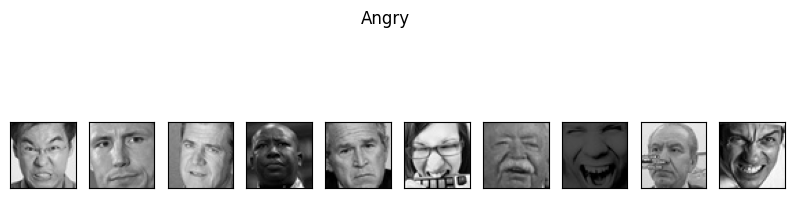

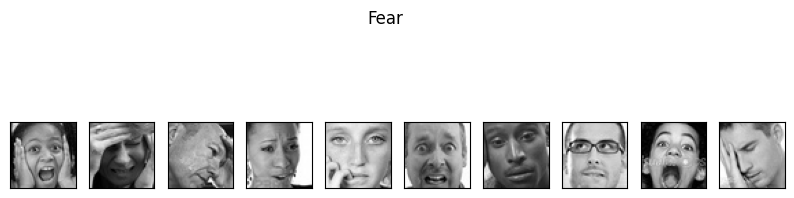

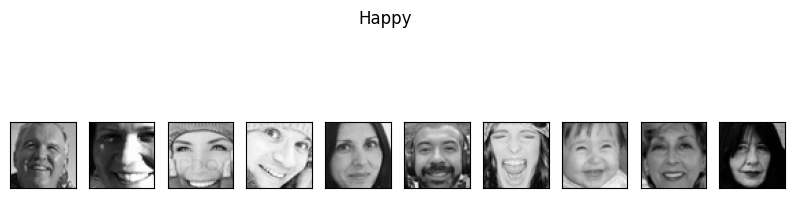

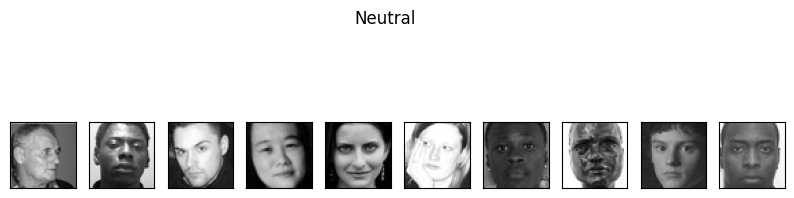

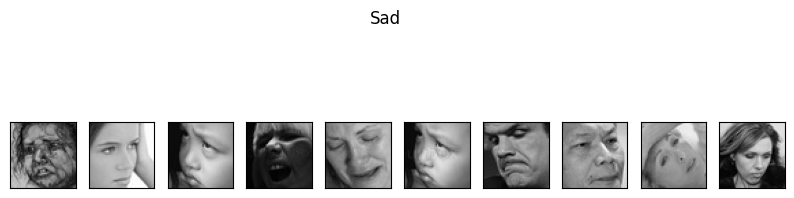

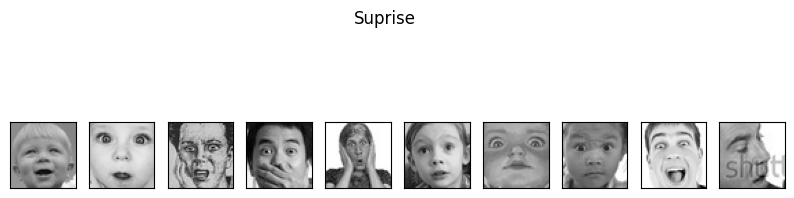

In [10]:
plot_samples(X_train, y_train, train_labels, 10)

**Encoding Classes**

Using the method to_categorical(), a numpy array (or) a vector which has integers that represent different categories, can be converted into a numpy array (or) a matrix which has binary values and has columns equal to the number of categories in the data.

In [11]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=len(train_labels))
Y_train.shape

(28273, 6)

In [12]:
Y_test = to_categorical(y_test, num_classes=len(test_labels))
Y_test.shape

(7067, 6)

# **Model Building**

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.

![](https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

In [13]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights=None,
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
NUM_CLASSES = len(train_labels)

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [15]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 150.8 MB/s eta 0:00:00


In [16]:
def deep_model(model, X_train, Y_train, X_val, Y_val, epochs, batch_size):
    model.compile(
        loss='binary_crossentropy',
        #optimizer=Adam(learning_rate=1e-4),
        optimizer=RMSprop(learning_rate=1e-4),
        metrics=['accuracy']
    )

    history = model.fit(
        X_train,
        Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),  # Add validation data here
        verbose=1
    )
    return history

In [17]:
# Save the model
model.save('full_emotion_model.keras')
print("Model saved successfully as full_emotion_model.keras")

Model saved successfully as full_emotion_model.keras


In [18]:
epochs = 40
batch_size = 64

history = deep_model(model, X_train, Y_train, X_test, Y_test, epochs, batch_size)

Epoch 1/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 62s 112ms/step - accuracy: 0.2390 - loss: 0.5010 - val_accuracy: 0.2510 - val_loss: 0.4450
Epoch 2/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - accuracy: 0.2457 - loss: 0.4465 - val_accuracy: 0.2510 - val_loss: 0.4451
Epoch 3/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.2563 - loss: 0.4453 - val_accuracy: 0.2510 - val_loss: 0.4445
Epoch 4/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.2507 - loss: 0.4457 - val_accuracy: 0.2510 - val_loss: 0.4442
Epoch 5/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.2534 - loss: 0.4453 - val_accuracy: 0.2510 - val_loss: 0.4450
Epoch 6/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.2534 - loss: 0.4451 - val_accuracy: 0.2510 - val_loss: 0.4441
Epoch 7/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.2533 - loss: 0.4451 - val_accuracy: 0.2510 - val_loss: 0.4443
Epoch 8/40
442/442 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.2564 - loss: 0.4448 -

In [19]:
# Load the model
from keras.models import load_model

# Load the saved model file
loaded_emotion_model = load_model('full_emotion_model.keras')

# Verify the model by printing the summary
loaded_emotion_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │       513,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         6,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,233,694 (58.11 MB)

 Trainable params: 15,233,694 (58.11 MB)

 Non-trainable params: 0 (0.00 B)

**Confusion Matrix**

Additionally, the sensitivity, specificity, F-score, and accuracy are calculated for each class by using the following calculated confusion matrix Fig for the six classes for emotion detection. Each class is used against all classes in order to find those performance factors related to it.



In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Test Accuracy = 0.60


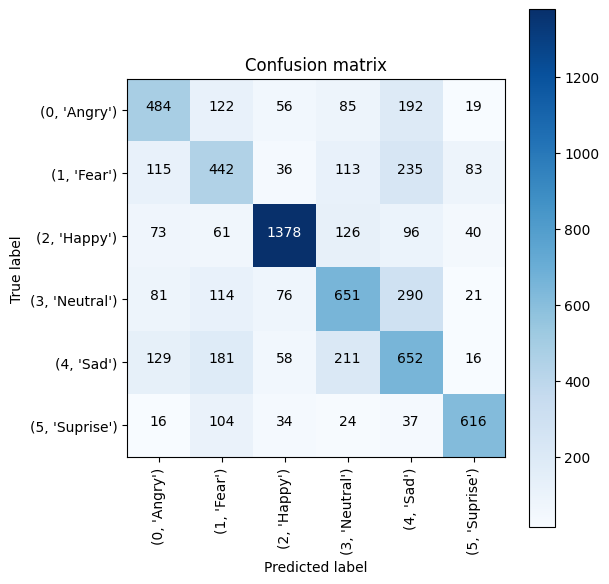

In [21]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred)
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

**Let's try our model and make predictions**

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7067 images belonging to 6 classes.


In [23]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


In [24]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [25]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Angry,Angry
1,Angry/Angry-10.jpg,Sad,Angry
2,Angry/Angry-100.jpg,Sad,Angry
3,Angry/Angry-101.jpg,Angry,Angry
4,Angry/Angry-102.jpg,Angry,Angry


# Visualizing Train,Test--->Accuracy,Loss

<Figure size 640x480 with 0 Axes>

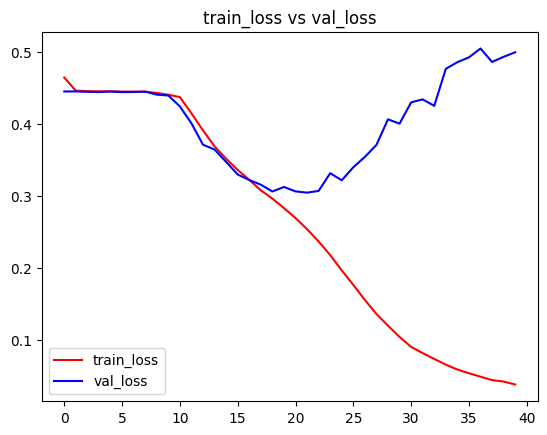

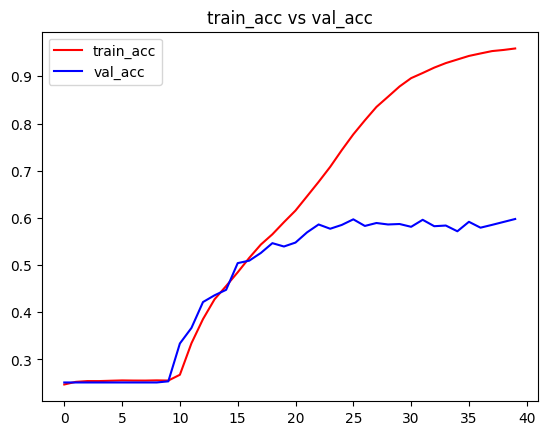

<Figure size 640x480 with 0 Axes>

In [26]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

# ROC Curve

In [27]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle

In [28]:
new_label = list(test_labels.values())
final_label = new_label
new_class = NUM_CLASSES

In [29]:
# The y_pred variable is a list of strings, which does not have a .ravel() method.
# For ROC curve calculation, we need the raw prediction probabilities, which are in the 'predictions' array.
# The 'y_test' variable is a 1D array of integer labels, which needs to be one-hot encoded (using Y_test).
lw = 2

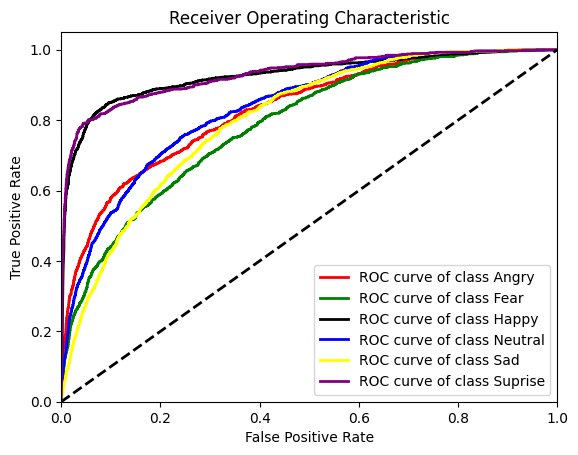

In [30]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    # Use Y_test (one-hot encoded true labels) and predictions (raw probability scores)
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['red', 'green','black','blue', 'yellow','purple'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()